In [18]:
from implicit.evaluation import  *
from implicit.als import AlternatingLeastSquares as ALS
from implicit.bpr import BayesianPersonalizedRanking as BPR
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn.utils import shuffle
from scipy.sparse import *
# import rec_util
pd.options.display.float_format = '{:.2f}'.format
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

# 데이터 로드

In [1]:
song_meta = pd.read_json('./raw_data/song_meta.json')
train = pd.read_json('./raw_data/train.json')
val = pd.read_json('./raw_data/val.json')
genre = pd.read_json('./raw_data/genre_gn_all.json', typ = 'seriese')

In [11]:
song_meta.head()

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2
3,"[GN1102, GN1101]",20151016,Feeling Right (Everything Is Nice) (Feat. Popc...,2644882,[838543],Feeling Right (Everything Is Nice) (Feat. Popc...,[GN1100],[Matoma],3
4,"[GN1802, GN1801]",20110824,그남자 그여자,2008470,[560160],그남자 그여자,[GN1800],[Jude Law],4


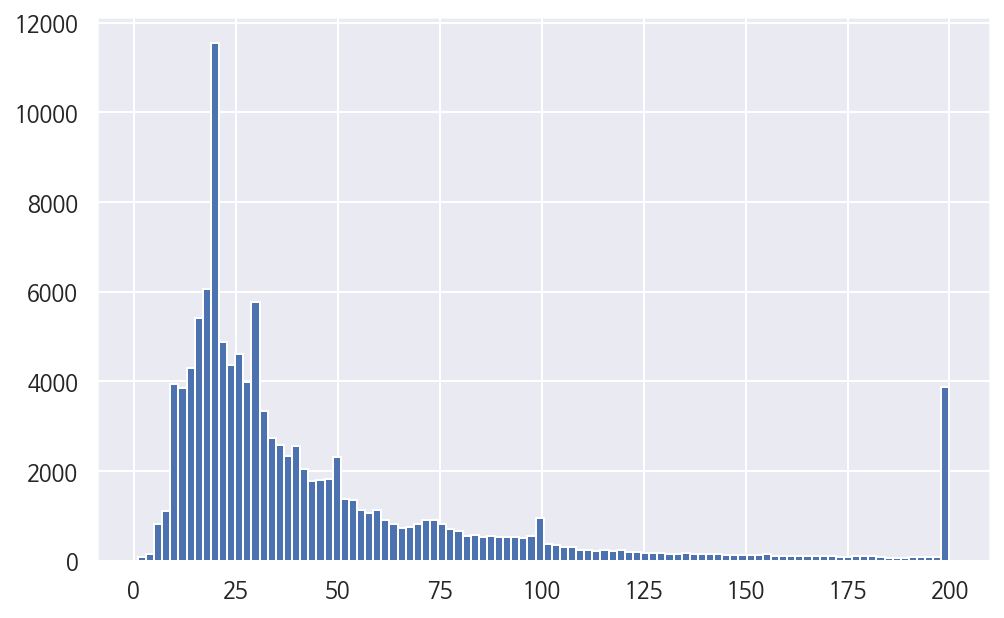

In [13]:
plt.hist(train['songs'].apply(len), bins=100)
plt.show()

In [5]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23015 entries, 0 to 23014
Data columns (total 6 columns):
tags            23015 non-null object
id              23015 non-null int64
plylst_title    23015 non-null object
songs           23015 non-null object
like_cnt        23015 non-null int64
updt_date       23015 non-null object
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


In [4]:
val[val['plylst_title'].apply(len) != 0]

,tags,id,plylst_title,songs,like_cnt,updt_date
1,[],131447,앨리스테이블,[],1,2014-07-16 15:24:24.000
8,[스트레스],80810,리듬타면서 빡시게 운동하자!!!(스트레스 날리자):},[],127,2017-02-09 17:33:45.000
9,[],142007,기분 좋은 재즈와 함께 만드는 달달한 하루,[],0,2015-06-22 09:11:02.000
17,[생각나],2380,다시 생각나는 그 사람,[],6,2016-03-19 23:53:20.000
20,"[피아노, 이루마, 메로디]",149069,불면증엔 아름다운 뉴에이지 곡들,[],11,2019-12-15 19:15:21.000
...,...,...,...,...,...,...
22991,[],32537,컨트리 황제 조니 캐시가 선 레코드 시절 발표한 초기 대표작,[],28,2019-06-17 14:22:48.000
22992,[사랑],32812,♥옷차림이 가벼워질때 부담없이 듣는음악♥,[],8,2015-05-08 00:09:01.000
22996,[],86721,해 저무는 밤,[],5,2016-04-27 15:32:55.000
23002,"[텐션, 명곡, 학창시절, 텐션업]",56570,숨어듣는명곡! 텐션올릴때듣는 그시절그노래!! (그냥명곡있을수있음주의),[],538,2020-04-18 22:02:07.000


## id별 장르 구분

In [2]:
## id별 장르 구분

song_meta[['id','song_gn_dtl_gnr_basket','song_gn_gnr_basket']]

song_meta['total_gn'] = song_meta['song_gn_dtl_gnr_basket'] + song_meta['song_gn_gnr_basket']

song_meta[['id','total_gn']]

df = song_meta[['id','total_gn']].explode('total_gn')
# df1.explode('song_gn_dtl_gnr_basket')
df

,id,total_gn
0,0,GN0901
0,0,GN0900
1,1,GN1601
1,1,GN1606
1,1,GN1600
...,...,...
707987,707987,GN1801
707987,707987,GN1800
707988,707988,GN0601
707988,707988,GN0604


In [3]:
df1 = pd.get_dummies(df['total_gn']).max(level=0).reset_index()

In [4]:
df1.rename(columns={'index': 'id'}, inplace=True)

In [5]:
df1

,id,GN0100,GN0101,GN0102,GN0103,GN0104,GN0105,GN0200,GN0201,GN0202,...,GN2802,GN2803,GN2804,GN2805,GN2806,GN2900,GN2901,GN2902,GN2903,GN9000
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707984,707984,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
707985,707985,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
707986,707986,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
707987,707987,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 연, 월

In [89]:
song_meta['issue_year'] = song_meta['issue_date'].apply(lambda x : str(x)[:4] if len(str(x)) != 1 else '0' )

In [90]:
song_meta['issue_month'] = song_meta['issue_date'].apply(lambda x :  str(x)[4:6] if len(str(x)) != 1 else '0')

In [91]:
# 이거는 안넣을거
song_meta['issue_day'] = song_meta['issue_date'].apply(lambda x :  str(x)[6:] if len(str(x)) != 1 else '0')

In [92]:
song_meta[['id','issue_year','issue_month','issue_day']]

,id,issue_year,issue_month,issue_day
0,0,2014,05,12
1,1,2008,04,21
2,2,2018,05,18
3,3,2015,10,16
4,4,2011,08,24
...,...,...,...,...
707984,707984,1999,12,19
707985,707985,1986,00,00
707986,707986,2016,01,20
707987,707987,2013,12,17


## df 합체

In [49]:
df = df1.merge(song_meta[['id','issue_year','issue_month']],on='id')

In [10]:
song_meta.shape

(707989, 12)

In [11]:
df

,id,GN0100,GN0101,GN0102,GN0103,GN0104,GN0105,GN0200,GN0201,GN0202,...,GN2804,GN2805,GN2806,GN2900,GN2901,GN2902,GN2903,GN9000,issue_year,issue_month
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2014,05
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2008,04
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2018,05
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2015,10
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2011,08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707984,707984,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1999,12
707985,707985,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1986,00
707986,707986,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,2016,01
707987,707987,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2013,12


## playlist like

In [12]:
# 함수 사용 안함
def playlist_like_cnt(x):
    ls = []
    for song in x['songs']:
        ls.append({'song':song,'like_cnt':x['like_cnt']})       
    return ls

In [13]:
ls = []
for i in train[['songs','like_cnt']].index:
    songs = train.get_value(i,'songs')
    like_cnt = train.get_value(i,'like_cnt')
    for song in songs:
        ls.append({'id':song,'like_cnt': like_cnt})

In [14]:
result_df = pd.DataFrame(ls)

In [15]:
playlist_like_df = result_df.groupby('id').agg(sum)

In [16]:
playlist_like_df

,like_cnt
id,
0,29
3,1686
4,39
5,391
6,24
...,...
707984,2
707985,11
707986,1123


## df 합체

In [50]:
df = df.merge(playlist_like_df, on='id',how='outer')

In [18]:
df

,id,GN0100,GN0101,GN0102,GN0103,GN0104,GN0105,GN0200,GN0201,GN0202,...,GN2805,GN2806,GN2900,GN2901,GN2902,GN2903,GN9000,issue_year,issue_month,like_cnt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2014,05,29.0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2008,04,NaN
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2018,05,NaN
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2015,10,1686.0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2011,08,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707984,707984,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1999,12,2.0
707985,707985,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1986,00,11.0
707986,707986,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2016,01,1123.0
707987,707987,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2013,12,4.0


# playlist에 담겨진 횟수

In [19]:
ls = []
for i in train[['id','songs']].index:
    songs = train.get_value(i,'songs')
    playlist_id = train.get_value(i,'id')
    for song in songs:
        ls.append({'id':song,'population': playlist_id})

In [20]:
playlits_id = pd.DataFrame(ls)

In [21]:
population_df = playlits_id.groupby('id').count()

## df 합체

In [51]:
df = df.merge(population_df, on='id',how='outer')

In [23]:
## population이 nan 이면
## playlist에도 안들어가 있고
## 따라서 like_cnt도 없다!
df[df['population'].isnull()]

,id,GN0100,GN0101,GN0102,GN0103,GN0104,GN0105,GN0200,GN0201,GN0202,...,GN2806,GN2900,GN2901,GN2902,GN2903,GN9000,issue_year,issue_month,like_cnt,population
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2008,04,NaN,NaN
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2018,05,NaN,NaN
8,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2007,06,NaN,NaN
13,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2016,11,NaN,NaN
15,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2014,09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707962,707962,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2014,08,NaN,NaN
707968,707968,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2013,05,NaN,NaN
707971,707971,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1996,00,NaN,NaN
707973,707973,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1997,00,NaN,NaN


# Tag score

### tag 전체에서 몇번 들어 갔는지

In [24]:
ls = []
for i in train[['tags','id']].index:
    tags = train.get_value(i,'tags')
    playlist_id = train.get_value(i,'id')
    for tag in tags:
        ls.append({'tag_id':tag,'count': playlist_id})

In [25]:
tag_df = pd.DataFrame(ls)

In [26]:
tag_count_df = tag_df.groupby('tag_id').count().reset_index()

In [27]:
tag_count_df

,tag_id,count
0,,1
1,00,4
2,007,3
3,007시리즈,2
4,00s,3
...,...,...
29155,힙해,5
29156,힙힙힙,2
29157,힛뎀포크,1
29158,힛뎀폭,1


## 노래별로 어떤 tag가 붙어있는지

In [28]:
ls = []
for i in train[['tags','songs']].index:
    tags = train.get_value(i,'tags')
    songs = train.get_value(i,'songs')
    for song in songs:
        ls.append({'id':song,'tags': tags})

In [29]:
song_tag = pd.DataFrame(ls)

In [30]:
song_tag_df = song_tag.groupby('id').agg(sum).reset_index()

In [31]:
song_tag_df

,id,tags
0,0,"[비오는날, 드라이브, 비오는날, 추억, 회상]"
1,3,"[1, 감성, 듣기좋은, 드라이브, Pop, 여행, 기분전환, 팝, 신나는, 클럽,..."
2,4,"[뉴에이지, 뉴에이지]"
3,5,"[비오는날, 재즈, 락, 발라드, 휴식, 리메이크, 재즈, 힐링송, 힐링, 기분전환..."
4,6,"[클래식, 산책, 조깅]"
...,...,...
615137,707984,[월드뮤직]
615138,707985,"[Pop, 해외차트, 시대별차트, 신디로퍼, Pop, 1980, 라이벌, 록]"
615139,707986,"[힙합, 랩, 발라드, 감성, 리메이크곡, 카페, 잔잔한, 추억, 위로, 힐링, 사..."
615140,707987,"[집중, 노동요, 새벽, 오후, 자장가, 공부]"


## 노래별로 붙어있는 tag의 count를 구해서 다 더 해주자

In [32]:
song_tag_df.iloc[0]['tags']

['비오는날', '드라이브', '비오는날', '추억', '회상']

In [33]:
from tqdm import tqdm
ls = []
for i in tqdm(song_tag_df[['id','tags']].index):
    id_ = song_tag_df.get_value(i, 'id')
    tags = song_tag_df.get_value(i, 'tags')
    ls.append({
        "id": id_,
        "count": tag_count_df[tag_count_df['tag_id'].isin(tags)]['count'].values.sum()
    })

100%|██████████| 615142/615142 [31:58<00:00, 320.64it/s]


In [42]:
tag_score = pd.DataFrame(ls)

In [43]:
tag_score.shape

(615142, 2)

In [63]:
tag_score = tag_score.rename({'count':'tag_score'},axis='columns')

In [64]:
tag_score

,id,tag_score
0,0,24176
1,3,79205
2,4,3493
3,5,59069
4,6,4982
...,...,...
615137,707984,243
615138,707985,4323
615139,707986,162809
615140,707987,12775


## df 합체

In [96]:
final_df = df.merge(tag_score, on='id',how='outer')

In [98]:
final_df

,id,GN0100,GN0101,GN0102,GN0103,GN0104,GN0105,GN0200,GN0201,GN0202,...,GN2900,GN2901,GN2902,GN2903,GN9000,issue_year,issue_month,like_cnt,population,tag_score
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2014,05,29.0,2.0,24176.0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2008,04,NaN,NaN,NaN
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2018,05,NaN,NaN,NaN
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2015,10,1686.0,8.0,79205.0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2011,08,39.0,2.0,3493.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707984,707984,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1999,12,2.0,1.0,243.0
707985,707985,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1986,00,11.0,4.0,4323.0
707986,707986,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,2016,01,1123.0,11.0,162809.0
707987,707987,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2013,12,4.0,1.0,12775.0


In [67]:
song_meta.shape

(707989, 12)

In [70]:
song_meta_KNN_df = song_meta.merge(final_df, on='id')

## df pc 저장 (용량 큽니다)

In [76]:
final_df.to_json('./df_for_KNN.json')

In [72]:
song_meta_KNN_df.to_json('./df_for_KNN_and_song_meta.json')

## KNN 테스트 진행해보면 됩니다

### 데이터 로드

In [1]:
final_df = pd.read_json('./df_for_KNN.json')

In [2]:
final_df['tag_score'].describe()

count    615142.000000
mean      36540.735828
std       50220.117203
min           1.000000
25%        3493.000000
50%       15728.000000
75%       48018.000000
max      370989.000000
Name: tag_score, dtype: float64

In [3]:
final_df['population'].describe()

count    615142.000000
mean          8.592928
std          39.481912
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        2175.000000
Name: population, dtype: float64

In [4]:
final_df['like_cnt'].describe()

count    615142.000000
mean       1508.641172
std        6652.869225
min           0.000000
25%          13.000000
50%          76.000000
75%         563.000000
max      326947.000000
Name: like_cnt, dtype: float64

## 연도를 one-hot-encoding 진행

In [5]:
final_df_year_month_dummies = pd.get_dummies(final_df[['issue_year','issue_month']]).reset_index()

In [6]:
final_df_year_month_dummies.rename(columns={'index':'id'},inplace=True)

In [7]:
final_df_one_hot = final_df[final_df.columns.difference(['issue_year','issue_month'])].merge(final_df_year_month_dummies, on='id')

In [8]:
final_df_one_hot_copy = final_df_one_hot.copy()

## 최빈값으로 채우기

In [9]:
most_freq = final_df_one_hot_copy['like_cnt'].value_counts(dropna=True).idxmax()

In [10]:
final_df_one_hot_copy['like_cnt'] = final_df_one_hot_copy['like_cnt'].fillna(most_freq)

In [11]:
most_freq = final_df_one_hot_copy['population'].value_counts(dropna=True).idxmax()

In [12]:
final_df_one_hot_copy['population'] = final_df_one_hot_copy['population'].fillna(most_freq)

In [13]:
most_freq = final_df_one_hot_copy['tag_score'].value_counts(dropna=True).idxmax()

In [14]:
final_df_one_hot_copy['tag_score'] = final_df_one_hot_copy['tag_score'].fillna(most_freq)

## 결측치 확인

In [15]:
### 데이터 로드

final_df = pd.read_json('./df_for_KNN.json')

final_df['tag_score'].describe()

final_df['population'].describe()

final_df['like_cnt'].describe()

## 연도를 one-hot-encoding 진행

final_df_year_month_dummies = pd.get_dummies(final_df[['issue_year','issue_month']]).reset_index()

final_df_year_month_dummies.rename(columns={'index':'id'},inplace=True)

final_df_one_hot = final_df[final_df.columns.difference(['issue_year','issue_month'])].merge(final_df_year_month_dummies, on='id')

final_df_one_hot_copy = final_df_one_hot.copy()

## 최빈값으로 채우기

most_freq = final_df_one_hot_copy['like_cnt'].value_counts(dropna=True).idxmax()

final_df_one_hot_copy['like_cnt'] = final_df_one_hot_copy['like_cnt'].fillna(most_freq)

most_freq = final_df_one_hot_copy['population'].value_counts(dropna=True).idxmax()

final_df_one_hot_copy['population'] = final_df_one_hot_copy['population'].fillna(most_freq)

most_freq = final_df_one_hot_copy['tag_score'].value_counts(dropna=True).idxmax()

final_df_one_hot_copy['tag_score'] = final_df_one_hot_copy['tag_score'].fillna(most_freq)

## 결측치 확인

final_df_one_hot_copy[final_df_one_hot_copy.notnull()]final_df_one_hot_copy[final_df_one_hot_copy.notnull()]

,GN0100,GN0101,GN0102,GN0103,GN0104,GN0105,GN0200,GN0201,GN0202,GN0203,...,GN2901,GN2902,GN2903,GN9000,id,like_cnt,population,tag_score,issue_year,issue_month
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,29.0,2.0,24176.0,2014,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.0,1.0,2155.0,2008,4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0.0,1.0,2155.0,2018,5
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,1686.0,8.0,79205.0,2015,10
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,39.0,2.0,3493.0,2011,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,707984,2.0,1.0,243.0,1999,12
707985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,707985,11.0,4.0,4323.0,1986,0
707986,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,707986,1123.0,11.0,162809.0,2016,1
707987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,707987,4.0,1.0,12775.0,2013,12


In [16]:
final_df_one_hot_copy.shape

(707989, 255)

## id만 발라내기

In [17]:
final_df_no_id = final_df_one_hot_copy[final_df_one_hot_copy.columns.difference(['id'])]

In [18]:
final_df_no_id[['population','like_cnt','tag_score']]

,population,like_cnt,tag_score
0,2.0,29.0,24176.0
1,1.0,0.0,2155.0
2,1.0,0.0,2155.0
3,8.0,1686.0,79205.0
4,2.0,39.0,3493.0
...,...,...,...
707984,1.0,2.0,243.0
707985,4.0,11.0,4323.0
707986,11.0,1123.0,162809.0
707987,1.0,4.0,12775.0


In [19]:
from sklearn.preprocessing import minmax_scale

In [20]:
MinMax_scaled = minmax_scale(final_df_no_id, axis=0, copy=True, )

In [21]:
df_for_KNN = pd.DataFrame(MinMax_scaled, columns = final_df_no_id.columns)

# KNN

In [69]:
df_for_KNN

,GN0100,GN0101,GN0102,GN0103,GN0104,GN0105,GN0200,GN0201,GN0202,GN0203,...,GN2900,GN2901,GN2902,GN2903,GN9000,issue_month,issue_year,like_cnt,population,tag_score
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.10,1.00,0.00,0.00,0.07
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.08,0.99,0.00,0.00,0.01
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.10,1.00,0.00,0.00,0.01
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.20,1.00,0.01,0.00,0.21
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.16,0.99,0.00,0.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707984,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.24,0.99,0.00,0.00,0.00
707985,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.98,0.00,0.00,0.01
707986,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.02,1.00,0.00,0.00,0.44
707987,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.24,1.00,0.00,0.00,0.03


# train test split

In [23]:
from sklearn.model_selection import train_test_split
train_X, test_X , train_y, test_y = train_test_split(df_for_KNN, final_df_one_hot_copy['id'], test_size = 0.2, random_state = 100)

In [24]:
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(566391, 254)
(141598, 254)
(566391,)
(141598,)


## KNN 테스트

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
k_list = range(1000,10000,1000)
accuracies = []
for k in tqdm(k_list):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(train_X, train_y)
    accuracies.append(classifier.score(test_X, test_y))
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Breast Cancer Classifier Accuracy")
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

# Step1. ASL song_meta X features matrix => song 100곡

### 데이터 로드

In [1]:
raw_final_df = pd.read_json('./df_for_KNN.json')

In [120]:
final_df = final_df[final_df.columns.difference(['issue_year','issue_month'])]

In [121]:
final_df['tag_score'].describe()

count   615142.00
mean     36540.74
std      50220.12
min          1.00
25%       3493.00
50%      15728.00
75%      48018.00
max     370989.00
Name: tag_score, dtype: float64

In [122]:
final_df['population'].describe()

count   615142.00
mean         8.59
std         39.48
min          1.00
25%          1.00
50%          2.00
75%          4.00
max       2175.00
Name: population, dtype: float64

In [123]:
final_df['like_cnt'].describe()

count   615142.00
mean      1508.64
std       6652.87
min          0.00
25%         13.00
50%         76.00
75%        563.00
max     326947.00
Name: like_cnt, dtype: float64

## 연도를 one-hot-encoding 진행

In [124]:
final_df[['issue_year','issue_month']] = final_df[['issue_year','issue_month']].astype('str')

KeyError: "None of [Index(['issue_year', 'issue_month'], dtype='object')] are in the [columns]"

In [6]:
final_df_year_month_dummies = pd.get_dummies(final_df[['issue_year','issue_month']]).reset_index()

In [7]:
final_df_year_month_dummies.rename(columns={'index':'id'},inplace=True)

In [8]:
final_df_one_hot = final_df[final_df.columns.difference(['issue_year','issue_month'])].merge(final_df_year_month_dummies, on='id')

In [125]:
final_df_one_hot_copy = final_df.copy()

## 최빈값으로 채우기

In [126]:
most_freq = final_df_one_hot_copy['like_cnt'].value_counts(dropna=True).idxmax()

In [127]:
final_df_one_hot_copy['like_cnt'] = final_df_one_hot_copy['like_cnt'].fillna(most_freq)

In [128]:
most_freq = final_df_one_hot_copy['population'].value_counts(dropna=True).idxmax()

In [129]:
final_df_one_hot_copy['population'] = final_df_one_hot_copy['population'].fillna(most_freq)

In [130]:
most_freq = final_df_one_hot_copy['tag_score'].value_counts(dropna=True).idxmax()

In [131]:
final_df_one_hot_copy['tag_score'] = final_df_one_hot_copy['tag_score'].fillna(most_freq)

## 결측치 확인

In [132]:
final_df_one_hot_copy[final_df_one_hot_copy.notnull()]

,GN0100,GN0101,GN0102,GN0103,GN0104,GN0105,GN0200,GN0201,GN0202,GN0203,...,GN2806,GN2900,GN2901,GN2902,GN2903,GN9000,id,like_cnt,population,tag_score
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,29.00,2.00,24176.00
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.00,1.00,2155.00
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0.00,1.00,2155.00
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,1686.00,8.00,79205.00
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,39.00,2.00,3493.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,707984,2.00,1.00,243.00
707985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,707985,11.00,4.00,4323.00
707986,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,707986,1123.00,11.00,162809.00
707987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,707987,4.00,1.00,12775.00


# ALS 모델 확인

In [133]:
final_df_one_hot_copy_no_id = final_df_one_hot_copy[final_df_one_hot_copy.columns.difference(['id'])]

In [160]:
final_df_one_hot_copy_no_id

,GN0100,GN0101,GN0102,GN0103,GN0104,GN0105,GN0200,GN0201,GN0202,GN0203,...,GN2805,GN2806,GN2900,GN2901,GN2902,GN2903,GN9000,like_cnt,population,tag_score
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,29.00,2.00,24176.00
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.00,1.00,2155.00
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.00,1.00,2155.00
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1686.00,8.00,79205.00
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,39.00,2.00,3493.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.00,1.00,243.00
707985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11.00,4.00,4323.00
707986,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1123.00,11.00,162809.00
707987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4.00,1.00,12775.00


In [161]:
from sklearn.preprocessing import minmax_scale

In [187]:
MinMax_scaled = minmax_scale(final_df_one_hot_copy_no_id, axis=0, copy=True)

In [164]:
df_for_ALS = pd.DataFrame(MinMax_scaled, columns = final_df_one_hot_copy_no_id.columns)

In [166]:
tr_csr = csr_matrix(df_for_ALS)
tr_csr

<707989x252 sparse matrix of type '<class 'numpy.float64'>'
	with 3928499 stored elements in Compressed Sparse Row format>

In [167]:
als_model = ALS(factors=64)

In [168]:
als_model.fit(tr_csr.T)

## regulization 없이

In [169]:
def show_recommended(ls):
    idx_ls = []
    for idx, score in ls:
        idx_ls.append(idx)

    return song_meta[song_meta['id'].isin(idx_ls)]

In [183]:
song_meta[song_meta['id'] == 279532]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
279532,"[GN0401, GN0403]",20050108,Back To The Soul Flight,47037,[3959],귀로,[GN0400],[나얼],279532


In [184]:
show_recommended(als_model.recommend(279532, tr_csr, N=10))

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
19,"[GN0805, GN0501, GN0502, GN0801, GN0509]",20150205,내가 부른 그림 2,2303168,[230399],무얼 기다리나 (Feat. 조원선),"[GN0500, GN0800]",[이영훈],19
76,"[GN1301, GN1302]",20170908,Eric B For President：Term 2 (Acoustic),10158580,[785379],Treat Yourself (Feat. Wale) (Acoustic),[GN1300],[Eric Bellinger],76
82,"[GN1907, GN1912, GN1902, GN1901]",20070404,Best Of The Indigo 2000-2006,382592,[160906],I Do!,[GN1900],[The Indigo],82
84,"[GN1601, GN1615, GN1610]",20060526,Choral Adagios,102000,"[163617, 262473, 29646]","Mozart : Ave Verum Corpus, K.618",[GN1600],"[Cambridge King`s College Choir, James Vivian,...",84
88,"[GN0901, GN0902, GN1001]",20170714,Ultralife,10050821,[873372],All About You,"[GN0900, GN1000]",[Oh Wonder],88
131,"[GN0302, GN0301]",20190507,Poor Boy,10281727,[1626549],"Backpack (Feat. 보이비, Paloalto)",[GN0300],[김선재],131
145,[GN1701],20180425,"POPS GARDEN : 불멸의 명곡 산책 (연주곡으로 듣는 추억의 팝송, 뉴에이지...",10161302,[595911],Besame Mucho,[GN1700],[Carl Doy],145
146,[GN1501],20120119,꽃미남 라면가게 OST 스페셜,2067326,[581071],러빙러빙,[GN1500],[윤새하],146
224,[GN0101],20071002,The Third Place,358975,[458],삶은 여행,[GN0100],[이상은],224
237,"[GN1912, GN1902, GN1901]",20161201,Luna,10019643,[1239794],片戀 / Katakoi (짝사랑),[GN1900],[Shionoya Sayaka],237


In [179]:
show_recommended(als_model.recommend(279532, tr_csr, N=10))

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
19,"[GN0805, GN0501, GN0502, GN0801, GN0509]",20150205,내가 부른 그림 2,2303168,[230399],무얼 기다리나 (Feat. 조원선),"[GN0500, GN0800]",[이영훈],19
76,"[GN1301, GN1302]",20170908,Eric B For President：Term 2 (Acoustic),10158580,[785379],Treat Yourself (Feat. Wale) (Acoustic),[GN1300],[Eric Bellinger],76
82,"[GN1907, GN1912, GN1902, GN1901]",20070404,Best Of The Indigo 2000-2006,382592,[160906],I Do!,[GN1900],[The Indigo],82
84,"[GN1601, GN1615, GN1610]",20060526,Choral Adagios,102000,"[163617, 262473, 29646]","Mozart : Ave Verum Corpus, K.618",[GN1600],"[Cambridge King`s College Choir, James Vivian,...",84
88,"[GN0901, GN0902, GN1001]",20170714,Ultralife,10050821,[873372],All About You,"[GN0900, GN1000]",[Oh Wonder],88
131,"[GN0302, GN0301]",20190507,Poor Boy,10281727,[1626549],"Backpack (Feat. 보이비, Paloalto)",[GN0300],[김선재],131
145,[GN1701],20180425,"POPS GARDEN : 불멸의 명곡 산책 (연주곡으로 듣는 추억의 팝송, 뉴에이지...",10161302,[595911],Besame Mucho,[GN1700],[Carl Doy],145
146,[GN1501],20120119,꽃미남 라면가게 OST 스페셜,2067326,[581071],러빙러빙,[GN1500],[윤새하],146
224,[GN0101],20071002,The Third Place,358975,[458],삶은 여행,[GN0100],[이상은],224
237,"[GN1912, GN1902, GN1901]",20161201,Luna,10019643,[1239794],片戀 / Katakoi (짝사랑),[GN1900],[Shionoya Sayaka],237


In [148]:
song_meta[song_meta['id'] == 279532]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
279532,"[GN0401, GN0403]",20050108,Back To The Soul Flight,47037,[3959],귀로,[GN0400],[나얼],279532


In [147]:
show_recommended(ls)

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
19,"[GN0805, GN0501, GN0502, GN0801, GN0509]",20150205,내가 부른 그림 2,2303168,[230399],무얼 기다리나 (Feat. 조원선),"[GN0500, GN0800]",[이영훈],19
41,"[GN1701, GN1703, GN1702]",20121109,Christmas (Deluxe Special Edition),2167838,[35370],Mis Deseos / Feliz Navidad (with Thalia),[GN1700],[Michael Buble],41
46,[GN1001],20060117,Anthology (1968-1985) (Digital),165123,[29590],Hello It`s Me (Single Version),[GN1000],[Todd Rundgren],46
70,"[GN0105, GN0101]",20121204,WINTER POETRY,2169041,[1741],너에게 전하지 못한 말,[GN0100],[신혜성],70
78,[GN1201],20140408,HM5：Deluxe Edition,3804368,[507801],Summertime (DJ Fresh Remix),[GN1200],[Young Gully],78
103,[GN1701],19991231,Dr. Cyclops` Dream,4702483,"[885178, 2288424, 2294058, 885176, 2216160]",Valse Macabre,[GN1700],"[Ben Allison, The Herbie Nichols Project, Tim ...",103
118,[GN1201],20170208,Mangoes,10037852,[1088807],Frames,[GN1200],[DRWN.],118
129,[GN0901],20010101,Billy Joel The Ultimate Collection,24000,[27193],The Longest Time,[GN0900],[Billy Joel],129
132,"[GN1209, GN1201]",20180518,Light of Mine (Deluxe),10149958,[730303],Ups & Downs,[GN1200],[KYLE],132
145,[GN1701],20180425,"POPS GARDEN : 불멸의 명곡 산책 (연주곡으로 듣는 추억의 팝송, 뉴에이지...",10161302,[595911],Besame Mucho,[GN1700],[Carl Doy],145


## reguliazation 0.08

In [65]:
song_meta[song_meta['id'] == 279532]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
279532,"[GN0401, GN0403]",20050108,Back To The Soul Flight,47037,[3959],귀로,[GN0400],[나얼],279532


In [66]:
song_meta[song_meta['id'] == 6]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
6,"[GN1601, GN1602, GN1614]",20170208,Sibelius: Symphony No. 2; Tapiola; Valse triste,10038397,"[162097, 100237]",Sibelius : Valse Triste Op.44 (시벨리우스 : 슬픈 왈츠 작...,[GN1600],"[Herbert Blomstedt, San Francisco Symphony]",6


In [67]:
song_meta[song_meta['id'] == 7]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
7,"[GN1601, GN1602, GN1614]",20190315,Celebrating John Williams (Live At Walt Disney...,10261160,"[105210, 261542]",Superman March (From &#34;Superman&#34; / Live...,[GN1600],"[Los Angeles Philharmonic Orchestra, Gustavo D...",7


In [73]:
song_meta[song_meta['id'] == 340]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
340,"[GN0302, GN0301]",20191105,OSU,10347210,[669972],"OSU (With. YunB, 메이스원더, jerd, YANU, FROG, Osca...",[GN0300],[올티 (Olltii)],340


In [78]:
als_model.recommend(279532, tr_csr, N=10)

[(344, 0.24754164),
 (343, 0.112633705),
 (6, 0.10417682),
 (7, 0.102936625),
 (342, 0.09831476),
 (184, 0.0921042),
 (185, 0.091890275),
 (341, 0.07131791),
 (222, 0.06694877),
 (221, 0.06641531)]

In [96]:
als_model.recommend(350,tr_csr,N=100)

[(659082, 1.1346464),
 (49564, 1.1345887),
 (188655, 1.1297991),
 (300556, 1.1297841),
 (550275, 1.1297246),
 (635470, 1.1296303),
 (196632, 1.1295819),
 (112623, 1.1292274),
 (187254, 1.1291416),
 (611380, 1.1288774),
 (277179, 1.1283739),
 (146711, 1.1281404),
 (685390, 1.127531),
 (46602, 1.1273488),
 (265973, 1.1273348),
 (60780, 1.127259),
 (287459, 1.1268742),
 (21759, 1.1268705),
 (345638, 1.1267924),
 (595294, 1.1267815),
 (386775, 1.1267761),
 (661669, 1.1267731),
 (73811, 1.1267707),
 (323512, 1.1267701),
 (694924, 1.1267233),
 (251982, 1.1267129),
 (347684, 1.1266811),
 (284318, 1.1266629),
 (366442, 1.1266202),
 (627270, 1.1266195),
 (327615, 1.1265962),
 (514648, 1.1265893),
 (40460, 1.1265674),
 (63564, 1.1265609),
 (228116, 1.1265537),
 (402379, 1.126551),
 (42387, 1.1265445),
 (669221, 1.1265329),
 (351067, 1.1265159),
 (471938, 1.1265087),
 (296205, 1.1265023),
 (378006, 1.1264807),
 (356924, 1.1264712),
 (651028, 1.12647),
 (24905, 1.1264699),
 (179046, 1.1264466),
 (

In [79]:
als_model.similar_items(0, N=50)

[(700255, 0.3770454),
 (359760, 0.3770454),
 (502466, 0.3770454),
 (310876, 0.3770454),
 (117988, 0.3770454),
 (585142, 0.3770454),
 (192227, 0.3770454),
 (579775, 0.3770454),
 (107729, 0.3770454),
 (95469, 0.3770454),
 (569480, 0.3770454),
 (198558, 0.3770454),
 (624214, 0.3770454),
 (588445, 0.3770454),
 (12770, 0.3770454),
 (466374, 0.3770454),
 (601169, 0.3770454),
 (639005, 0.3770454),
 (449718, 0.3770454),
 (130008, 0.3770454),
 (517912, 0.3770454),
 (177399, 0.3770454),
 (649866, 0.3770454),
 (112998, 0.3770454),
 (451054, 0.3770454),
 (326765, 0.3770454),
 (0, 0.3770454),
 (561019, 0.37704536),
 (683557, 0.37704536),
 (222995, 0.37704536),
 (459222, 0.37704536),
 (619497, 0.37704536),
 (39808, 0.37704536),
 (90428, 0.37704536),
 (252170, 0.37704536),
 (573172, 0.37704536),
 (497171, 0.37704536),
 (663644, 0.37704536),
 (461868, 0.37704536),
 (258088, 0.37704536),
 (216169, 0.37704536),
 (462833, 0.37704536),
 (593414, 0.37704536),
 (521773, 0.37704536),
 (213164, 0.37704536),
 

In [78]:
als_model.similar_items(10, N=10)

[(10, 0.42247477),
 (352904, 0.42247477),
 (237459, 0.42247474),
 (70721, 0.42247474),
 (266741, 0.4224747),
 (251011, 0.4224747),
 (103307, 0.42247468),
 (206068, 0.42247468),
 (291514, 0.42247465),
 (7567, 0.42247456)]

In [30]:
als_model.similar_items(0, N=10)

[(455580, 0.14952311),
 (389829, 0.14952311),
 (230243, 0.14952311),
 (29576, 0.14952311),
 (544117, 0.14952311),
 (240992, 0.14952311),
 (127842, 0.14952311),
 (0, 0.14952311),
 (519161, 0.1495231),
 (674615, 0.1495231)]

In [89]:
als_model.similar_items(12345, N=10)

[(12345, 0.40521675),
 (186346, 0.4052164),
 (2738, 0.40521637),
 (579531, 0.40521637),
 (45037, 0.40521604),
 (395565, 0.4052158),
 (35124, 0.40521574),
 (48780, 0.4052156),
 (692280, 0.40521544),
 (668340, 0.40521544)]

In [193]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

class SimilarityPredictions(object):
    '''This class calculates a similarity matrix from latent embeddings.
    Input: embeddings - a pandas dataframe of items and latent dimensions.
    '''

    def __init__(self, embeddings):
        self.embeddings = embeddings
        self.ids = embeddings.index.tolist()

    def calculate_cosine_similarity_matrix(self):
        '''Calculates a cosine similarity matrix from the embeddings'''
        similarity_matrix = pd.DataFrame(cosine_similarity(
            X=self.embeddings),
            index=self.ids)
        similarity_matrix.columns = self.ids
        return similarity_matrix

    def predict_similar_items(self, seed_item, n):
        '''Use the similarity_matrix to return n most similar items.'''
        similar_items = pd.DataFrame(self.similarity_matrix.loc[seed_item])
        similar_items.columns = ["similarity_score"]
        similar_items = similar_items.sort_values('similarity_score', ascending=False)
        similar_items = similar_items.head(n)
        similar_items.reset_index(inplace=True)
        similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
        return similar_items.to_dict()

In [198]:
similarityPredictions = SimilarityPredictions(df_for_ALS)

In [ ]:
df = similarityPredictions.calculate_cosine_similarity_matrix()

In [ ]:
predict_similar_items(0,100)